# Attrition Prediction IA Project Yoann

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from numpy.polynomial.polynomial import Polynomial
# Import sklearn

from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold

## Chargement et exploration des données

In [2]:
# Path to the dataset
src_path = "src/"
general_data_file_path = os.path.join(src_path, "general_data.csv")
employee_survey_data_file_path = os.path.join(src_path, "employee_survey_data.csv")
manager_survey_data_file_path = os.path.join(src_path, "manager_survey_data.csv")
in_time_file_path = os.path.join(src_path + "in_time.csv")
out_time_file_path = os.path.join(src_path + "out_time.csv")

# Load the dataset
general_data = pd.read_csv(general_data_file_path)
employee_survey_data = pd.read_csv(employee_survey_data_file_path)
manager_survey_data = pd.read_csv(manager_survey_data_file_path)
in_time_data = pd.read_csv(os.path.join(src_path, "in_time.csv"))
out_time_data = pd.read_csv(os.path.join(src_path, "out_time.csv"))

## Correction des noms de colonnes

Nous constatons que la première colonne des jeux de données in_time_data et out_time_data est nommée Unnamed: 0. Nous allons la renommer en EmployeeID pour une meilleure lisibilité.

In [3]:
# Replace Unnamed header by EmployeeID
in_time_data.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
out_time_data.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

## Calcul de travail journalier en heure

In [4]:
# Création de copie avec uniquement des inputs utilisable en ignorant la colonne EmployeeID

in_time_data_copy = in_time_data.iloc[:, 1:]
out_time_data_copy = out_time_data.iloc[:, 1:]

# Transformation en format datetime

in_time_data_copy = in_time_data_copy.apply(pd.to_datetime, errors='coerce')
out_time_data_copy = out_time_data_copy.apply(pd.to_datetime, errors='coerce')

# Calcul du temps de travail

time_work_data = out_time_data_copy - in_time_data_copy

# Conversion en heures
time_work_data_in_hours = time_work_data.map(lambda x: x.total_seconds() / 3600 if pd.notnull(x) else None)

# Affichage des résultats

time_work_data_in_hours.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,None,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,None,...,NaN,7.339167,7.395833,6.504722,7.596389,None,7.773889,7.315000,7.778889,7.080278
1,None,8.109167,7.454722,NaN,7.396944,7.416667,7.150833,7.611389,7.278889,None,...,7.903056,7.753889,7.712222,7.435556,NaN,None,7.614722,7.982500,7.986111,8.227222
2,None,6.692500,7.265556,6.405278,6.765000,7.345000,6.861389,7.418611,6.999722,None,...,6.785833,7.163611,6.801667,6.730278,6.849722,None,7.023889,7.438889,7.538889,6.786389
3,None,7.338333,7.291944,6.943056,6.919444,6.850833,7.193056,6.998611,7.306389,None,...,7.629167,6.846667,7.326389,7.413611,7.085000,None,7.447222,7.416667,7.366389,7.133056
4,None,8.055556,7.988056,7.682500,7.806111,7.662222,7.721667,8.365000,8.257222,None,...,7.903611,7.665000,7.957500,7.786944,8.249444,None,7.662222,8.268611,7.953333,8.018056


In [5]:
# Calculs pour chaque employé
summary_work_data = pd.DataFrame()
summary_work_data['EmployeeID'] = in_time_data['EmployeeID']

# Heure d'arrivé moyenne

summary_work_data['Avg_Hours_In'] = in_time_data_copy.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Heure de départ moyenne

summary_work_data['Avg_Hours_Out'] = out_time_data_copy.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Moyenne d'heures travaillées par jour
summary_work_data['Avg_Hours_Per_Day'] = time_work_data_in_hours.mean(axis=1, skipna=True)

# Nombre de jours travaillés dans l'année
summary_work_data['Days_Worked'] = time_work_data_in_hours.notnull().sum(axis=1)

# Total d'heures travaillées dans l'année
summary_work_data['Total_Hours_Worked'] = summary_work_data['Avg_Hours_Per_Day'] * summary_work_data['Days_Worked']

# Transforme les objets en float
summary_work_data['Avg_Hours_Per_Day'] = pd.to_numeric(summary_work_data['Avg_Hours_Per_Day'], errors='coerce')
summary_work_data['Total_Hours_Worked'] = pd.to_numeric(summary_work_data['Total_Hours_Worked'], errors='coerce')

# Affichage des résultats
summary_work_data.head()

,EmployeeID,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,1,9.993032,17.367170,7.373651,232,1710.686944
1,2,9.980720,17.698446,7.718969,236,1821.676667
2,3,10.016598,17.030096,7.013240,242,1697.204167
3,4,9.973830,17.167305,7.193678,235,1690.514444
4,5,9.990068,17.996327,8.006175,245,1961.512778


## Création du dataframe merged_data

Nous allons maintenant créer un dataframe qui contient toute les données des autres dataframes afin de manipuler plus facilement les données et de créer plus facilement des dataframe contenant uniquement les données que nous voulons tester.

In [6]:
# set into a dictionary
data = {
    'general_data': general_data,
    'employee_survey_data': employee_survey_data,
    'manager_survey_data': manager_survey_data,
    'summary_work_data': summary_work_data,
}

# Fusion de tous les DataFrames sur la clé "EmployeeID"
merged_data = data['general_data']
for key, df in data.items():
    if key != 'general_data':
        merged_data = pd.merge(merged_data, df, on='EmployeeID', how='inner')

merged_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,3.0,4.0,2.0,3,3,9.993032,17.367170,7.373651,232,1710.686944
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3.0,2.0,4.0,2,4,9.980720,17.698446,7.718969,236,1821.676667
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2.0,2.0,1.0,3,3,10.016598,17.030096,7.013240,242,1697.204167
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,4.0,4.0,3.0,2,3,9.973830,17.167305,7.193678,235,1690.514444
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,1.0,3.0,3,3,9.990068,17.996327,8.006175,245,1961.512778


In [7]:
# Vérifier la taille pour s'assurer qu'il y a bien le bon nombre d'employés
print(f"Nombre de lignes dans le DataFrame fusionné : {merged_data.shape[0]}")

Nombre de lignes dans le DataFrame fusionné : 4410


## Etude de notre dataset

### Analyse de forme

In [8]:
# On retire EmployeeID car elle ne sera pas utile lors du traitement
merged_data_copy = merged_data.drop('EmployeeID', axis=1)

y = merged_data_copy['Attrition']
X = merged_data_copy.drop('Attrition', axis=1)

In [9]:
merged_data_copy.shape

(4410, 33)

In [10]:
merged_data_copy.dtypes.value_counts()

int64      16
float64     9
object      8
Name: count, dtype: int64

<Axes: >

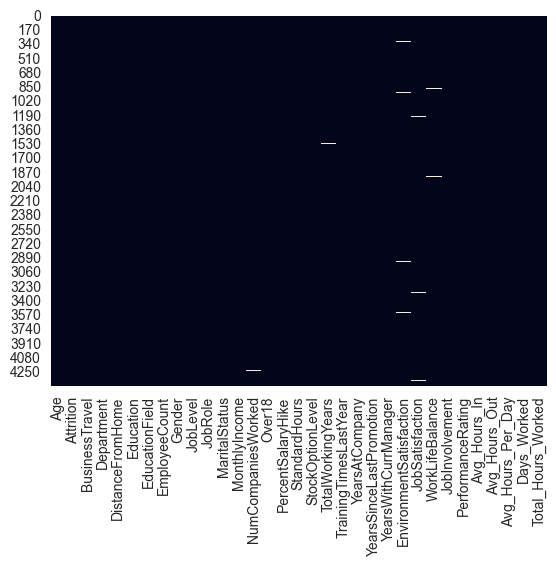

In [11]:
sns.heatmap(merged_data_copy.isna(), cbar=False)

In [12]:
(merged_data_copy.isna().sum()).sort_values(ascending=False)

WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
Avg_Hours_In                0
PerformanceRating           0
JobInvolvement              0
StockOptionLevel            0
Avg_Hours_Out               0
Avg_Hours_Per_Day           0
YearsWithCurrManager        0
YearsSinceLastPromotion     0
Days_Worked                 0
YearsAtCompany              0
TrainingTimesLastYear       0
Age                         0
StandardHours               0
Attrition                   0
PercentSalaryHike           0
Over18                      0
MonthlyIncome               0
MaritalStatus               0
JobRole                     0
JobLevel                    0
Gender                      0
EmployeeCount               0
EducationField              0
Education                   0
DistanceFromHome            0
Department                  0
BusinessTravel              0
Total_Hours_Worked          0
dtype: int

Très peu de NaN

### Analyse du fond

In [13]:
merged_data_copy['Attrition'].value_counts()

Attrition
No     3699
Yes     711
Name: count, dtype: int64

C:\Users\yoann\AppData\Local\Temp\ipykernel_20876\470010353.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data_copy[col])
C:\Users\yoann\AppData\Local\Temp\ipykernel_20876\470010353.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data_copy[col])
C:\Users\yoann\AppData\Loc

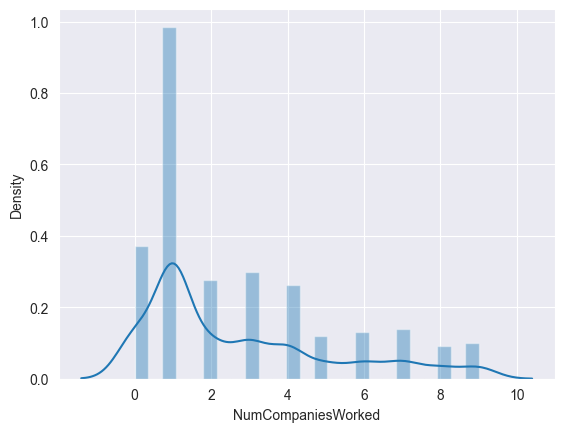

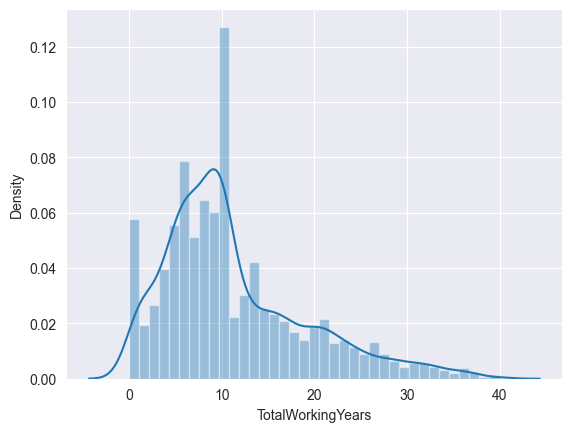

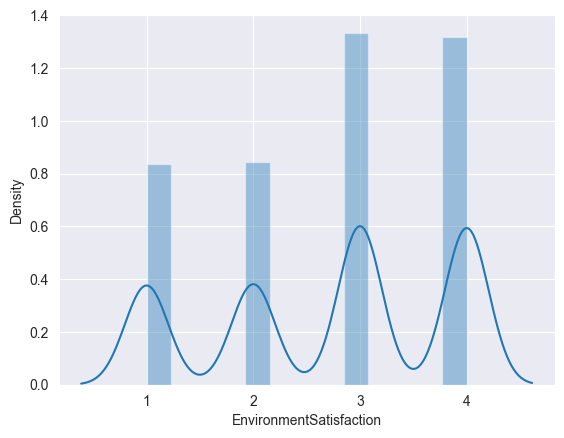

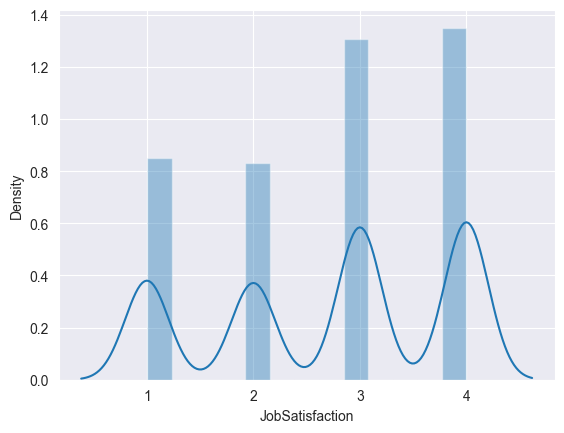

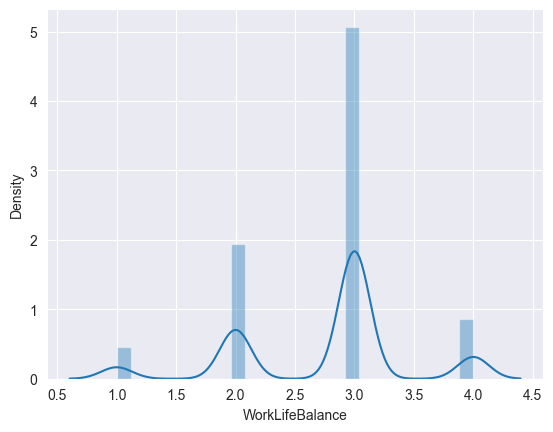

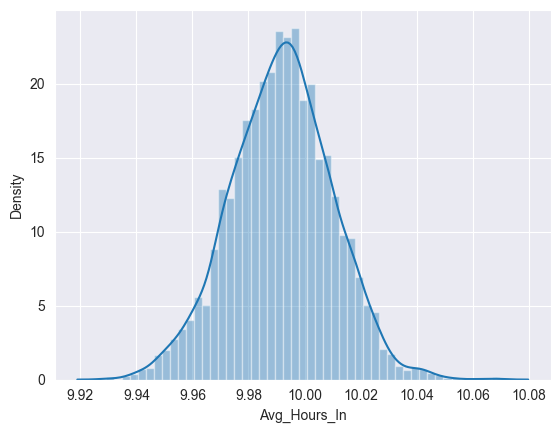

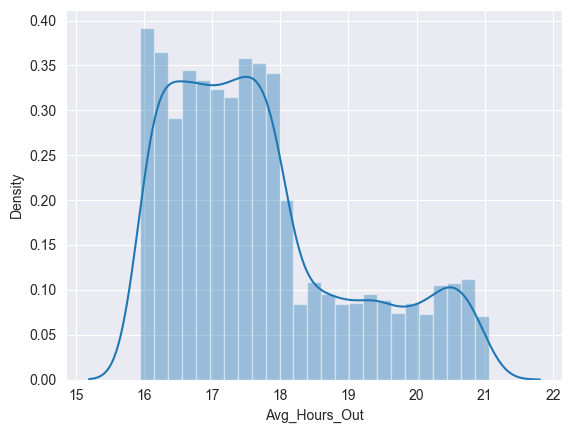

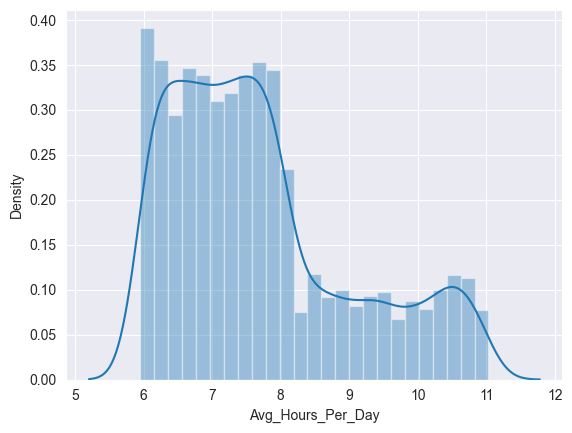

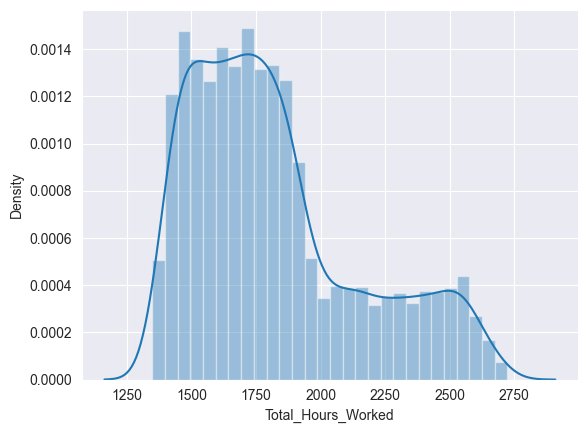

In [14]:
for col in merged_data_copy.select_dtypes('float'):
    plt.figure()
    sns.distplot(merged_data_copy[col])

In [15]:
for col in merged_data_copy.select_dtypes('object'):
    print(f'{col : <20} {merged_data_copy[col].unique()}')

Attrition            ['No' 'Yes']
BusinessTravel       ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department           ['Sales' 'Research & Development' 'Human Resources']
EducationField       ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender               ['Female' 'Male']
JobRole              ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus        ['Married' 'Single' 'Divorced']
Over18               ['Y']


On remarque que Over18 n'a qu'une valeur et n'est donc pas utile

### Création de sous-ensembles positifs et négatifs

In [16]:
positive_data = merged_data_copy[merged_data_copy['Attrition'] == "no"]
negative_data = merged_data_copy[merged_data_copy['Attrition'] == "yes"]

<Axes: xlabel='MaritalStatus', ylabel='count'>

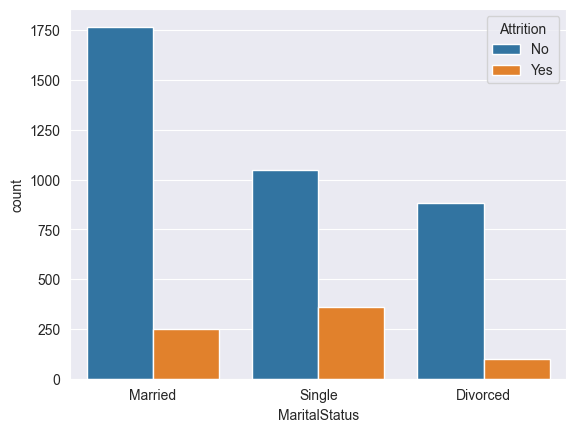

In [17]:
sns.countplot(x='MaritalStatus' ,hue='Attrition', data=merged_data_copy)

In [18]:
pd.crosstab(merged_data_copy['Attrition'], merged_data_copy['MaritalStatus'])

MaritalStatus,Divorced,Married,Single
Attrition,,,
No,882,1767,1050
Yes,99,252,360


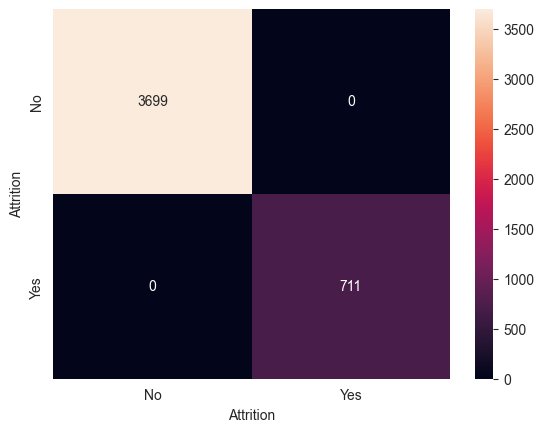

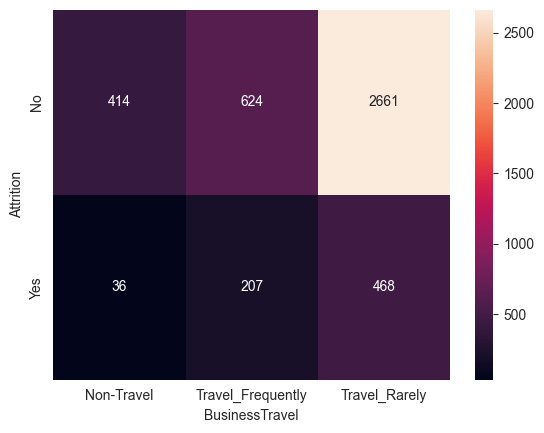

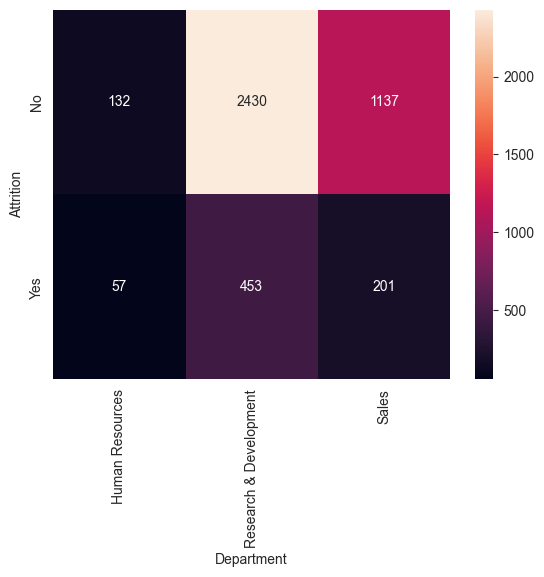

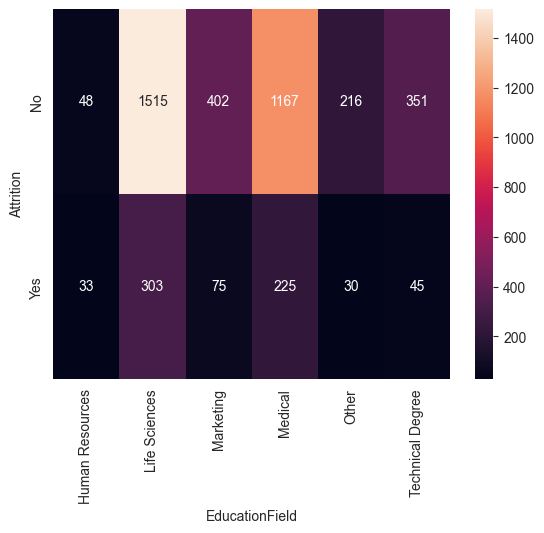

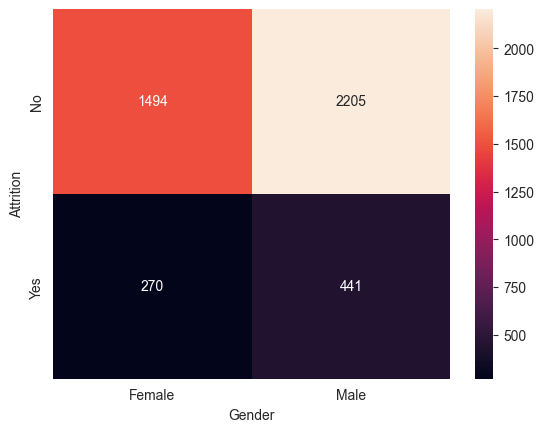

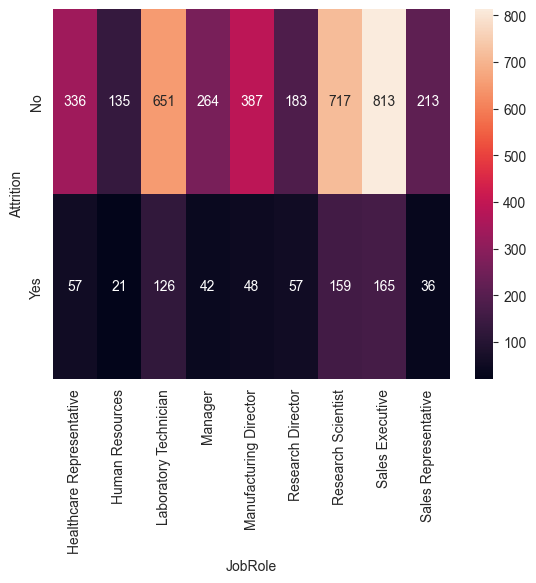

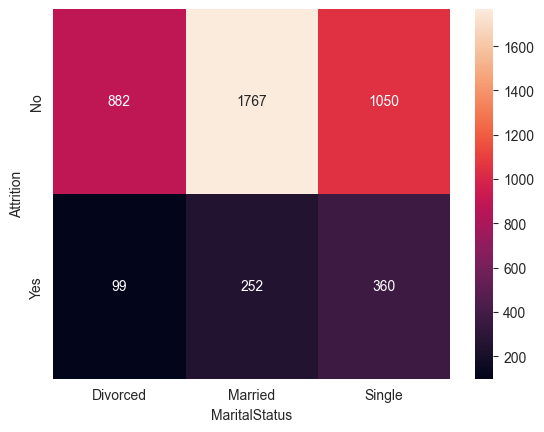

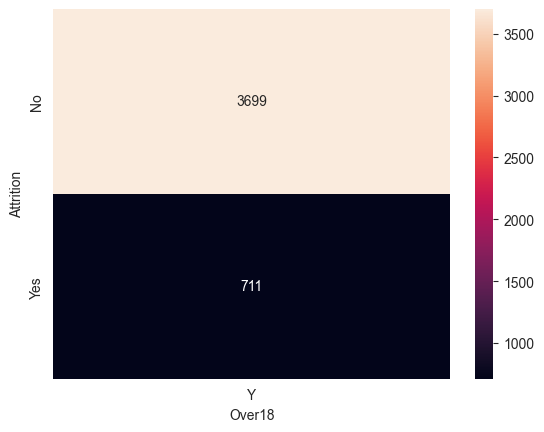

In [19]:
for col in merged_data_copy.select_dtypes('object'):
    plt.figure()
    sns.heatmap(pd.crosstab(merged_data_copy['Attrition'], merged_data_copy[col]), annot=True, fmt='d')

## Pre-Processing

In [20]:
merged_data_copy = merged_data.drop(['EmployeeID','Over18'], axis=1)
merged_data_copy.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3.0,4.0,2.0,3,3,9.993032,17.367170,7.373651,232,1710.686944
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,...,3.0,2.0,4.0,2,4,9.980720,17.698446,7.718969,236,1821.676667
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,...,2.0,2.0,1.0,3,3,10.016598,17.030096,7.013240,242,1697.204167
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,...,4.0,4.0,3.0,2,3,9.973830,17.167305,7.193678,235,1690.514444
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,...,4.0,1.0,3.0,3,3,9.990068,17.996327,8.006175,245,1961.512778


## TrainTest

In [21]:
trainset, testset = train_test_split((merged_data_copy), test_size=0.2, random_state=42)

In [22]:
trainset['Attrition'].value_counts()

Attrition
No     2958
Yes     570
Name: count, dtype: int64

In [23]:
testset['Attrition'].value_counts()

Attrition
No     741
Yes    141
Name: count, dtype: int64

### Encodage

In [24]:
def encodage(df):
    code = {
        'Non-Travel' :0, 'Travel_Rarely' :1, 'Travel_Frequently' :2,
        'Sales':0, 'Research & Development':1, 'Human Resources':2,
        'Life Sciences':0, 'Other' 'Medical' 'Marketing':1, 'Technical Degree':2, 'Human Resources':3,
        'Female':0, 'Male':1,
        'Healthcare Representative':0, 'Research Scientist':1, 'Sales Executive':2, 'Human Resources':3, 'Research Director':4, 'Laboratory Technician':5,
        'Manufacturing Director':6, 'Sales Representative':7, 'Manager':8,
        'Single':0, 'Married':1, 'Divorced':2,
        'No':0, 'Yes':1,
    }

    for col in df.select_dtypes('object'):
        df[col] = df[col].map(code)

    return df

In [25]:
def imputation(df):
    return df.dropna(axis=0)

In [26]:
def preprocessing(df):
    df = encodage(df)
    df = imputation(df)

    X = df.drop('Attrition', axis=1)
    y = df['Attrition']

    print(y.value_counts())

    return X, y

In [27]:
X_train, y_train = preprocessing(trainset)

Attrition
0    1495
1     301
Name: count, dtype: int64


In [28]:
X_test, y_test = preprocessing(testset)

Attrition
0    363
1     71
Name: count, dtype: int64


## Modelisation

In [29]:
constant_filter = VarianceThreshold(threshold=0)
X_train = constant_filter.fit_transform(X_train)
X_test = constant_filter.transform(X_test)

model = make_pipeline(SelectKBest(f_classif, k=7), RandomForestClassifier(random_state=42))

[[363   0]
 [  1  70]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       1.00      0.99      0.99        71

    accuracy                           1.00       434
   macro avg       1.00      0.99      1.00       434
weighted avg       1.00      1.00      1.00       434



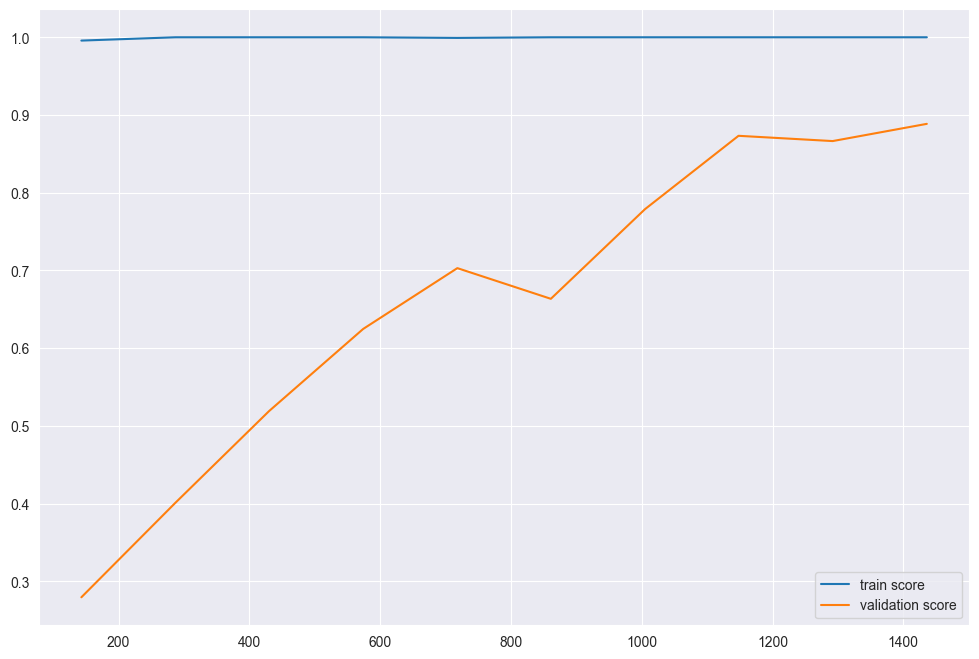

In [30]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='f1', train_sizes=np.linspace(.1, 1.0, 10))

    plt.figure(figsize = (12,8))
    plt.plot(N, train_score.mean(axis=1), label = 'train score')
    plt.plot(N, val_score.mean(axis=1), label = 'validation score')
    plt.legend()

evaluation(model)

In [31]:
#pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar()

## Modélisation

In [32]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=42))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=42))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=42))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

list_of_models = {
    'RandomForest': RandomForest,
    'AdaBoost' : AdaBoost,
    'SVM' : SVM,
    'KNN' : KNN
}

RandomForest
[[359   4]
 [ 20  51]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       363
           1       0.93      0.72      0.81        71

    accuracy                           0.94       434
   macro avg       0.94      0.85      0.89       434
weighted avg       0.94      0.94      0.94       434

AdaBoost
[[346  17]
 [ 56  15]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       363
           1       0.47      0.21      0.29        71

    accuracy                           0.83       434
   macro avg       0.66      0.58      0.60       434
weighted avg       0.80      0.83      0.80       434

SVM
[[350  13]
 [ 60  11]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.91       363
           1       0.46      0.15      0.23        71

    accuracy                           0.83       434
   macro avg       0.66      0.56

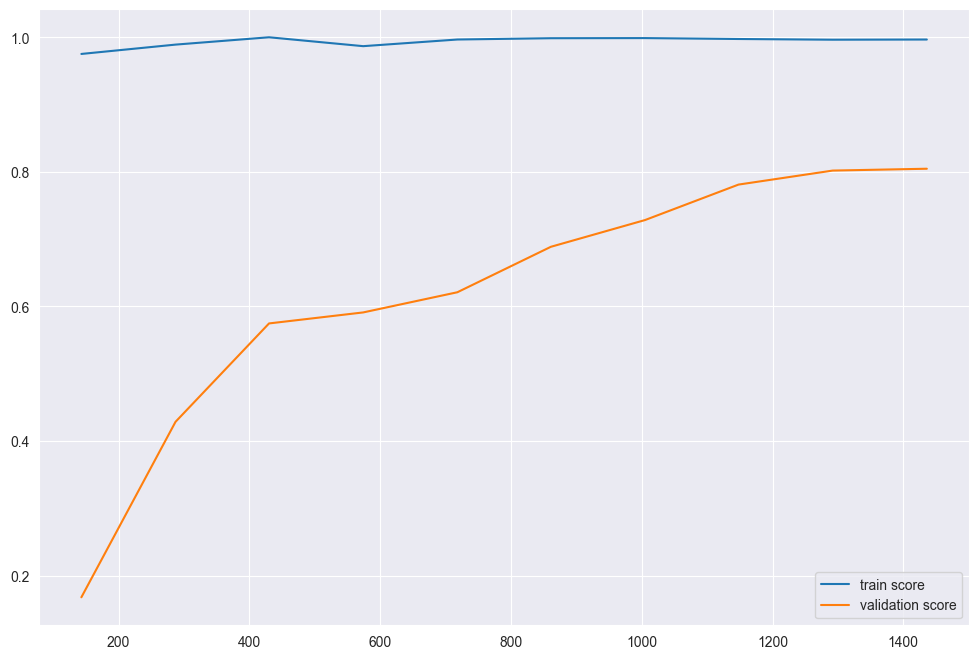

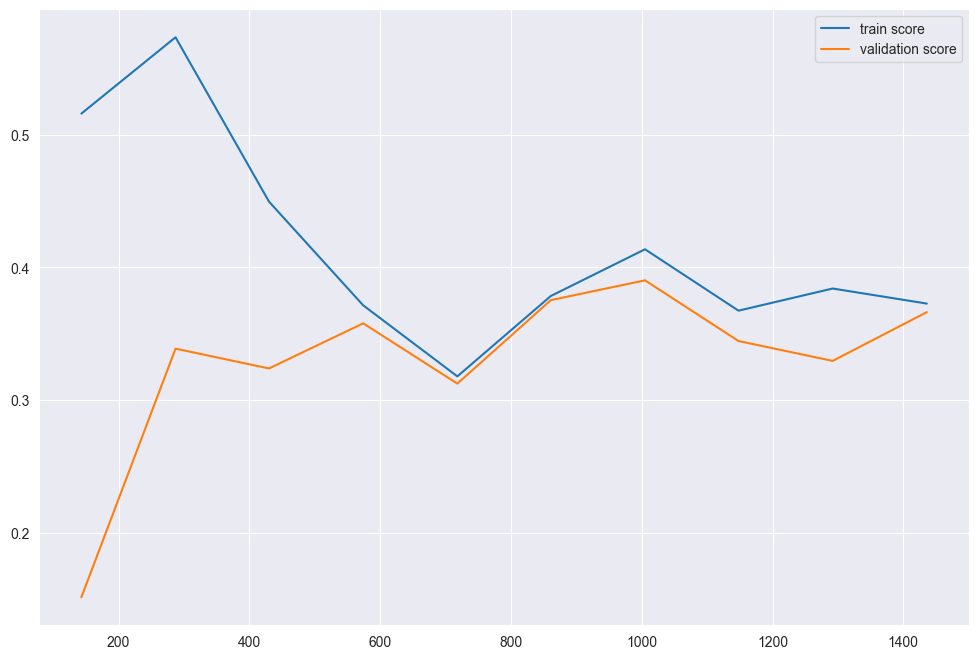

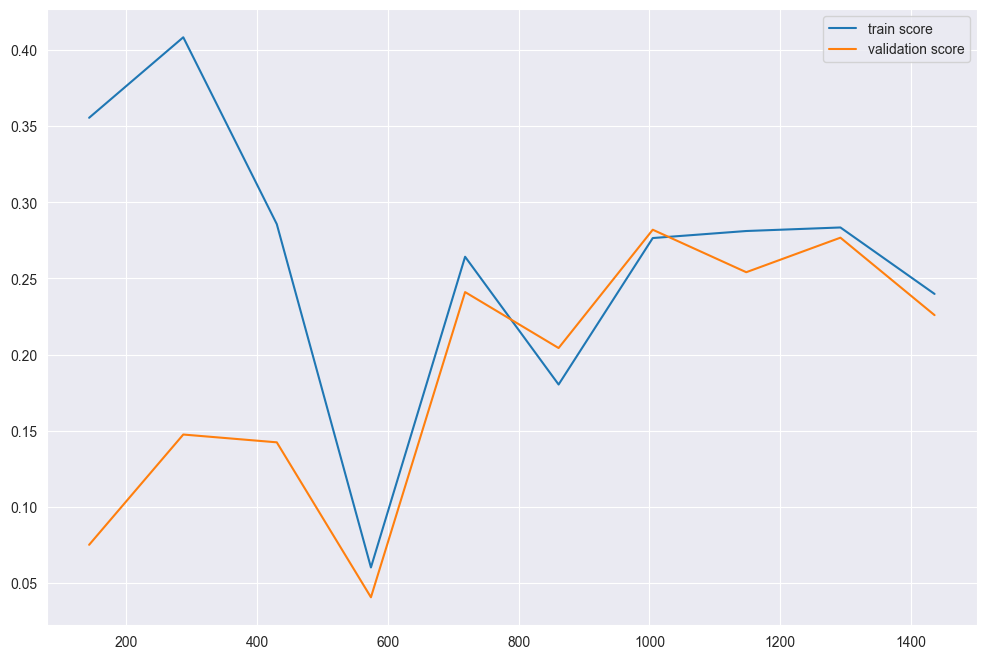

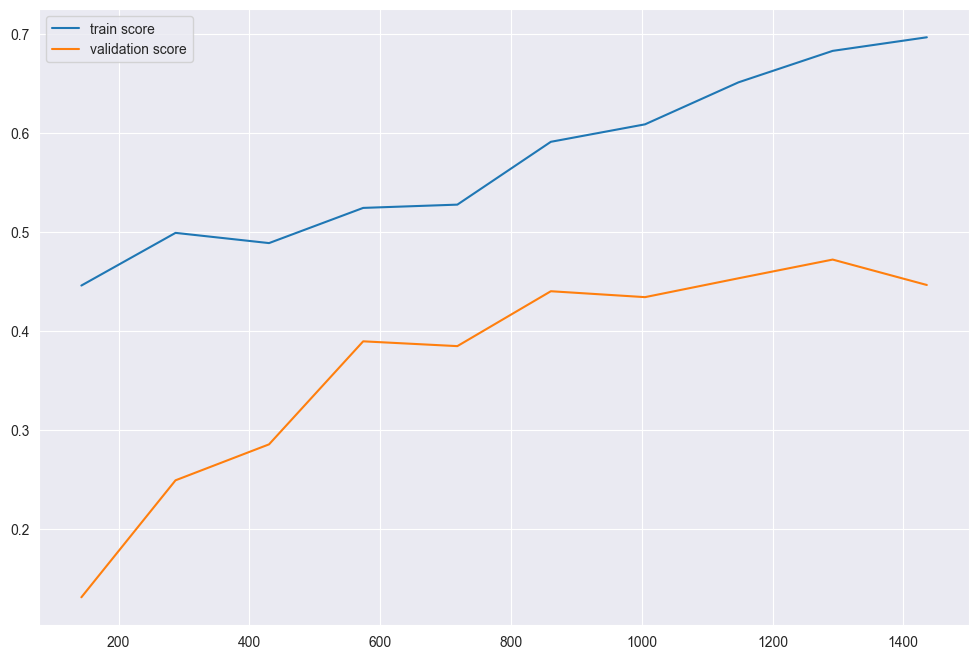

In [33]:
for name, model in list_of_models.items():
    print(name)
    evaluation(model)

### Optimisation

In [34]:
RandomForest

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 500}
[[359   4]
 [ 15  56]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       363
           1       0.93      0.79      0.85        71

    accuracy                           0.96       434
   macro avg       0.95      0.89      0.91       434
weighted avg       0.96      0.96      0.95       434



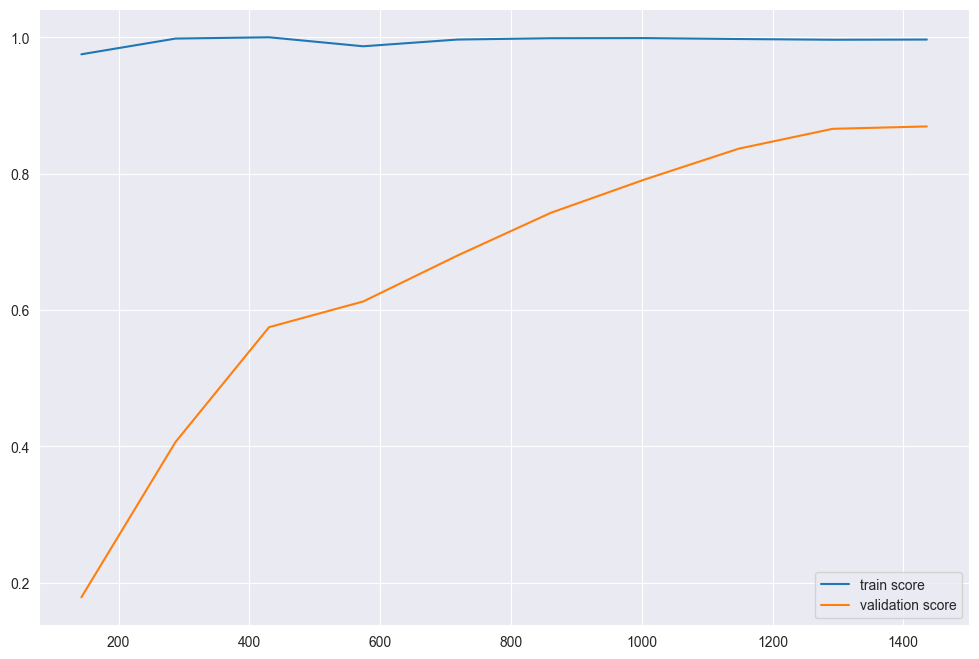

In [36]:
hyper_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 500, 1000],
    'randomforestclassifier__max_depth': [10, 20, 30, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForest, hyper_params, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

evaluation(grid.best_estimator_)